In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore

# Load the data
df = pd.read_csv('../data/benin-malanville.csv', parse_dates=['Timestamp'])

# Basic inspection
df.info()
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525600 entries, 0 to 525599
Data columns (total 19 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Timestamp      525600 non-null  datetime64[ns]
 1   GHI            525600 non-null  float64       
 2   DNI            525600 non-null  float64       
 3   DHI            525600 non-null  float64       
 4   ModA           525600 non-null  float64       
 5   ModB           525600 non-null  float64       
 6   Tamb           525600 non-null  float64       
 7   RH             525600 non-null  float64       
 8   WS             525600 non-null  float64       
 9   WSgust         525600 non-null  float64       
 10  WSstdev        525600 non-null  float64       
 11  WD             525600 non-null  float64       
 12  WDstdev        525600 non-null  float64       
 13  BP             525600 non-null  int64         
 14  Cleaning       525600 non-null  int64         
 15  

,Timestamp,GHI,DNI,DHI,ModA,ModB,Tamb,RH,WS,WSgust,WSstdev,WD,WDstdev,BP,Cleaning,Precipitation,TModA,TModB,Comments
0,2021-08-09 00:01:00,-1.2,-0.2,-1.1,0.0,0.0,26.2,93.4,0.0,0.4,0.1,122.1,0.0,998,0,0.0,26.3,26.2,NaN
1,2021-08-09 00:02:00,-1.1,-0.2,-1.1,0.0,0.0,26.2,93.6,0.0,0.0,0.0,0.0,0.0,998,0,0.0,26.3,26.2,NaN
2,2021-08-09 00:03:00,-1.1,-0.2,-1.1,0.0,0.0,26.2,93.7,0.3,1.1,0.5,124.6,1.5,997,0,0.0,26.4,26.2,NaN
3,2021-08-09 00:04:00,-1.1,-0.1,-1.0,0.0,0.0,26.2,93.3,0.2,0.7,0.4,120.3,1.3,997,0,0.0,26.4,26.3,NaN
4,2021-08-09 00:05:00,-1.0,-0.1,-1.0,0.0,0.0,26.2,93.3,0.1,0.7,0.3,113.2,1.0,997,0,0.0,26.4,26.3,NaN


In [2]:
# Summary statistics
df.describe()

# Missing values
missing_report = df.isna().sum()
missing_report[missing_report > 0]

# Columns with >5% nulls
threshold = 0.05 * len(df)
missing_report[missing_report > threshold]


Comments    525600
dtype: int64

In [3]:
cols_to_check = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']

# Z-scores
z_scores = df[cols_to_check].apply(zscore)
outliers = (np.abs(z_scores) > 3)

# Report
print(outliers.sum())

# Remove or impute
for col in cols_to_check:
    df[col] = df[col].fillna(df[col].median())

# Optional: Drop rows with extreme outliers
df_clean = df[(np.abs(z_scores) < 3).all(axis=1)]


GHI         89
DNI          0
DHI       3738
ModA        27
ModB        63
WS        3109
WSgust    3500
dtype: int64


In [4]:
df_clean.to_csv('../data/benin_clean.csv', index=False)


<Axes: title={'center': 'Irradiance & Temperature over Time'}, xlabel='Timestamp'>

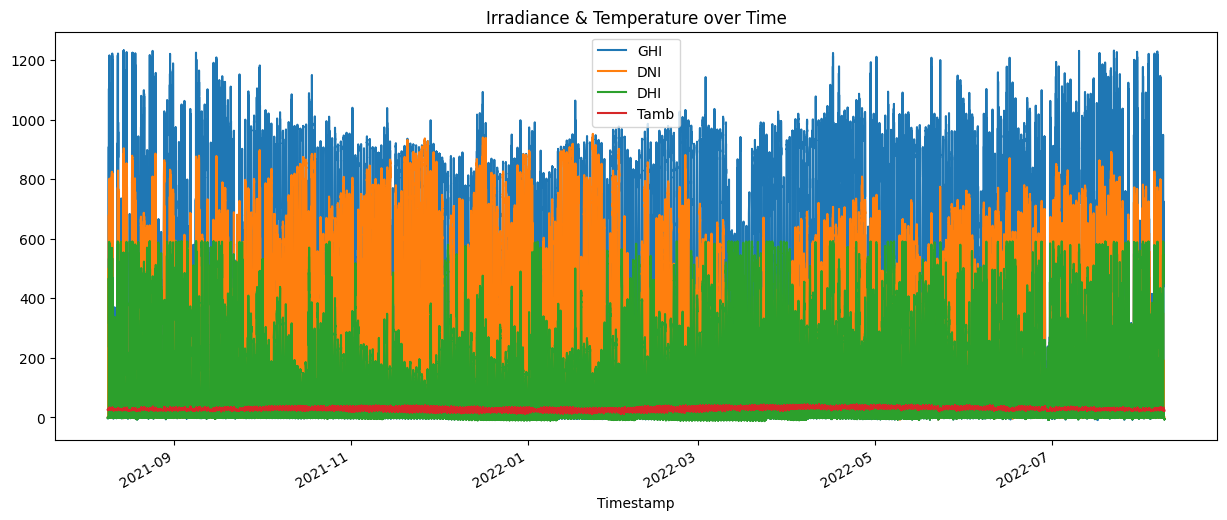

In [5]:
df_clean.set_index('Timestamp', inplace=True)

# Plotting
df_clean[['GHI', 'DNI', 'DHI', 'Tamb']].plot(figsize=(15,6), title='Irradiance & Temperature over Time')


/tmp/ipykernel_7616/2783995199.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['Month'] = df_clean.index.month
/tmp/ipykernel_7616/2783995199.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['Hour'] = df_clean.index.hour


<Axes: xlabel='Month', ylabel='GHI'>

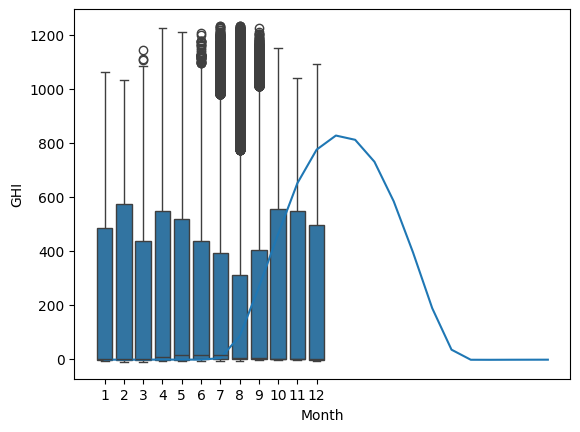

In [6]:
#Optional: Group by month/hour to analyze trends:

df_clean['Month'] = df_clean.index.month
df_clean['Hour'] = df_clean.index.hour

sns.boxplot(x='Month', y='GHI', data=df_clean)
sns.lineplot(x='Hour', y='GHI', data=df_clean.groupby('Hour')['GHI'].mean().reset_index())


/tmp/ipykernel_7616/3086293384.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['CleaningFlag'] = df_clean['Cleaning'].apply(lambda x: 'Cleaned' if x == 1 else 'Not Cleaned')


<Axes: title={'center': 'Module Output by Cleaning Event'}, xlabel='CleaningFlag'>

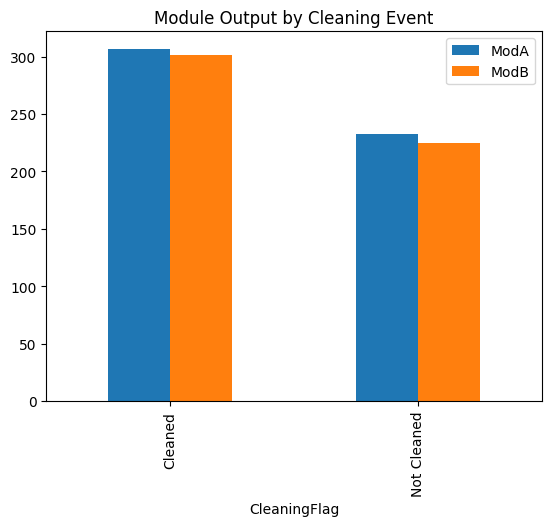

In [8]:
# Create a new column to flag cleaning events
df_clean['CleaningFlag'] = df_clean['Cleaning'].apply(lambda x: 'Cleaned' if x == 1 else 'Not Cleaned')

# Now group and plot
df_clean.groupby('CleaningFlag')[['ModA', 'ModB']].mean().plot(kind='bar', title='Module Output by Cleaning Event')


<Axes: xlabel='WS', ylabel='GHI'>

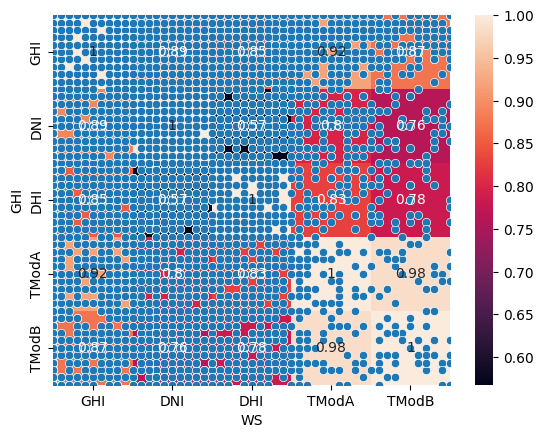

In [9]:
# Heatmap
sns.heatmap(df_clean[['GHI', 'DNI', 'DHI', 'TModA', 'TModB']].corr(), annot=True)

# Scatter plots
sns.scatterplot(x='WS', y='GHI', data=df_clean)
sns.scatterplot(x='RH', y='Tamb', data=df_clean)


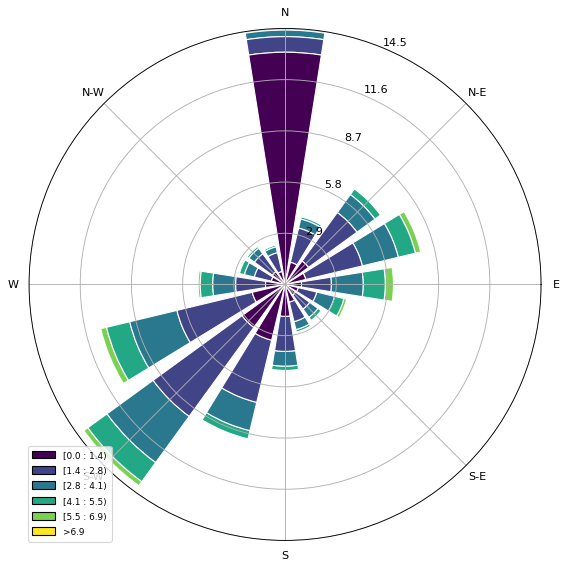

In [11]:
import matplotlib.cm as cm
from windrose import WindroseAxes

ax = WindroseAxes.from_ax()
ax.bar(df_clean['WD'], df_clean['WS'], normed=True, opening=0.8, edgecolor='white')
ax.set_legend()


array([[<Axes: title={'center': 'GHI'}>, <Axes: title={'center': 'WS'}>]],
      dtype=object)

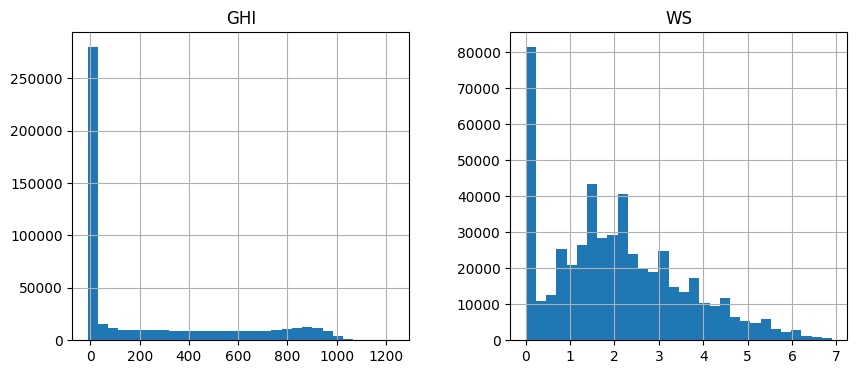

In [12]:
df_clean[['GHI', 'WS']].hist(bins=30, figsize=(10, 4))


<Axes: xlabel='RH', ylabel='Tamb'>

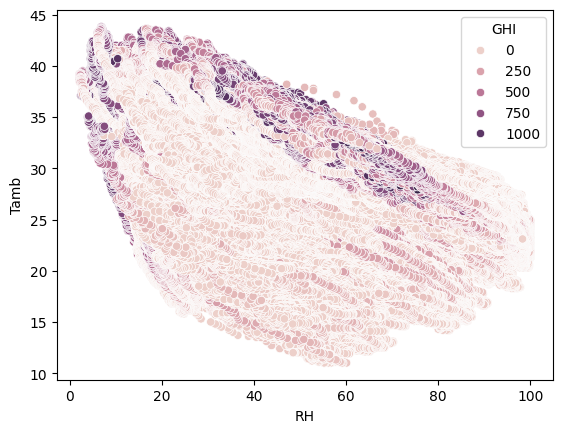

In [13]:
sns.scatterplot(x='RH', y='Tamb', hue='GHI', data=df_clean)


Text(0.5, 1.0, 'GHI vs Tamb (Bubble size = RH)')

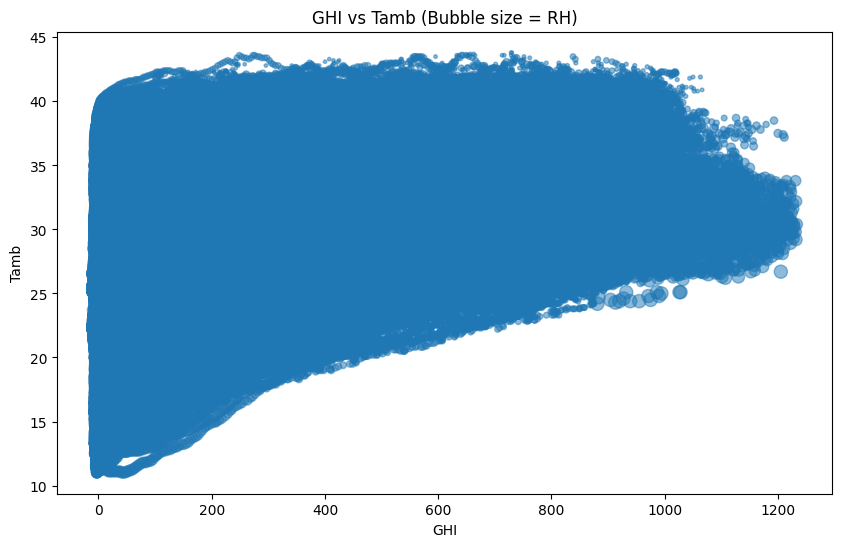

In [14]:
plt.figure(figsize=(10, 6))
plt.scatter(df_clean['GHI'], df_clean['Tamb'], s=df_clean['RH'], alpha=0.5)
plt.xlabel('GHI')
plt.ylabel('Tamb')
plt.title('GHI vs Tamb (Bubble size = RH)')

